In [1]:
import joblib as jl
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout, Embedding, Multiply, Concatenate, Input
from tensorflow.keras.models import Sequential, Model

In [2]:
x_out_train_a = jl.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks_3/dataset_2909.pkl')
x_out_train_b = jl.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks_3/dataset_0311.pkl')
x_out_test = jl.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks_3/dataset_1812.pkl')

In [3]:
# Separar los datos en arrays de numpy
images_train_a = x_out_train_a['images']
intervals_train_a = x_out_train_a['intervals']
labels_train_a = x_out_train_a['labels']

images_train_b = x_out_train_b['images']
intervals_train_b = x_out_train_b['intervals']
labels_train_b = x_out_train_b['labels']

images_test = x_out_test['images']
intervals_test = x_out_test['intervals']
labels_test = x_out_test['labels']

In [4]:
# Concatenar los arrays de entrenamiento
images_train = np.concatenate((images_train_a, images_train_b), axis=0)
labels_train = np.concatenate((labels_train_a, labels_train_b), axis=0)

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convertir las etiquetas a formato categórico
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels_train)

one_hot_encoder = OneHotEncoder(sparse_output=False)
labels_train_categorical = one_hot_encoder.fit_transform(integer_encoded_labels.reshape(-1, 1))

num_classes = labels_train_categorical.shape[1]


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LeakyReLU, BatchNormalization, Dropout, Concatenate, Input
from tensorflow.keras.models import Sequential, Model

# Crear el generador condicional
def build_generator(noise_dim, num_classes):
    noise = Input(shape=(noise_dim,))
    label = Input(shape=(num_classes,))

    model_input = Concatenate()([noise, label])

    x = Dense(128)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1601 * 64, activation='tanh')(x)
    output = Reshape((1601, 64, 1))(x)

    model = Model([noise, label], output)
    return model

# Crear el discriminador condicional
def build_discriminator(img_shape, num_classes):
    img = Input(shape=img_shape)
    label = Input(shape=(num_classes,))

    # Embedding de la etiqueta y redimensionamiento
    label_embedding = Dense(np.prod(img_shape))(label)
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenar la imagen con la etiqueta embebida
    model_input = Concatenate(axis=-1)([img, label_embedding])

    x = Conv2D(16, kernel_size=3, strides=2, padding='same')(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model([img, label], output)
    return model

# Crear la GAN condicional
def build_gan(generator, discriminator):
    discriminator.trainable = False

    noise = Input(shape=(noise_dim,))
    label = Input(shape=(num_classes,))

    generated_img = generator([noise, label])
    validity = discriminator([generated_img, label])

    model = Model([noise, label], validity)
    return model

# Hiperparámetros
noise_dim = 100
img_shape = (1601, 64, 1)
batch_size = 16
epochs = 700

# Crear y compilar el discriminador
discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Crear el generador
generator = build_generator(noise_dim, num_classes)

# Crear y compilar la GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')


c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
def train_gan(epochs, batch_size, noise_dim, generator, discriminator, gan, x_train, y_train):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict([noise, labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size)
        sampled_labels = one_hot_encoder.transform(sampled_labels.reshape(-1, 1))

        g_loss = gan.train_on_batch([noise, sampled_labels], valid)

        if epoch % 10 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

# Entrenar la GAN condicional
train_gan(epochs, batch_size, noise_dim, generator, discriminator, gan, images_train, labels_train_categorical)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\backend\tensorflow\trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 3.3381357192993164 | D accuracy: 56.25] [G loss: 0.6918272972106934]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
10 [D loss: 2.6521108150482178 | D accuracy: 31.99404776096344] [G loss: 0.5227557420730591]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
20 [D loss: 2.791407585144043 | D accuracy: 29.371732473373413] [G 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


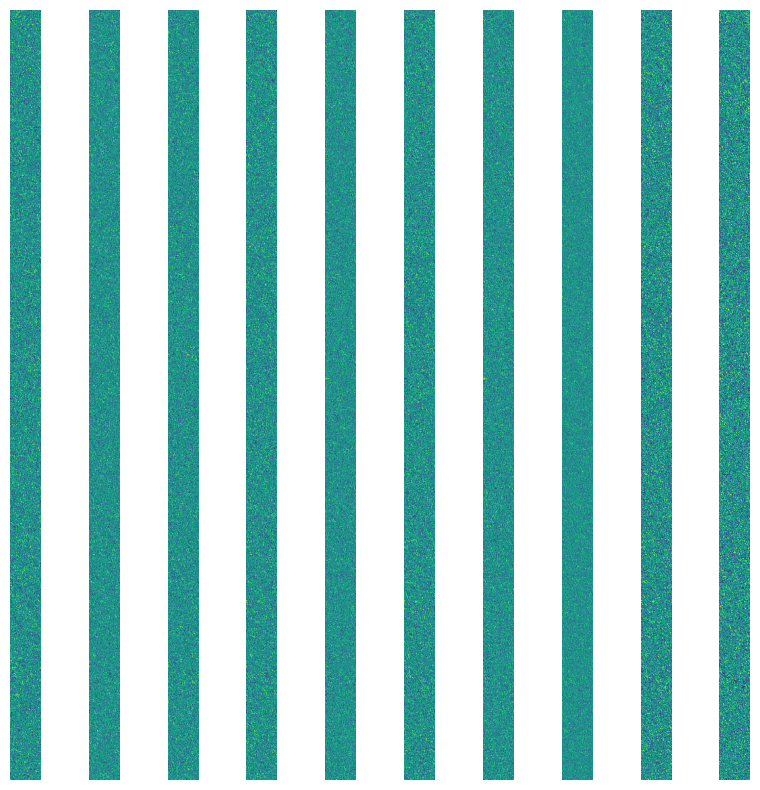

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_examples(generator, noise_dim, num_examples, labels):
    # Generate noise as input for the generator
    noise = np.random.normal(0, 1, (num_examples, noise_dim))
    
    # Generate images from the noise and the provided labels
    generated_images = generator.predict([noise, labels])
    
    # Rescale images to [0, 1] if necessary (depends on your preprocessing)
    generated_images = 0.5 * generated_images + 0.5
    
    return generated_images

# Assuming the GAN has been trained already, generate 10 examples
num_examples = 10

# Assuming the number of classes is known and one-hot encoder is available
sampled_labels = np.random.randint(0, num_classes, num_examples)
sampled_labels = one_hot_encoder.transform(sampled_labels.reshape(-1, 1))

# Generate images
generated_images = generate_examples(generator, noise_dim, num_examples, sampled_labels)

# Plotting the generated images
plt.figure(figsize=(10, 10))
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()
